# Pobranie danych oraz odfiltrowanie informacji nie związanych z badanymi zagadnieniami

## Import danych z Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
import os

os.chdir('/content')
zip_dir = '/content/gdrive/MyDrive/Kaggle/BGGData.zip'

!cp '{zip_dir}' .
!unzip -q 'BGGData.zip'

os.listdir()

['.config',
 'mechanics.csv',
 'ratings_distribution.csv',
 'themes.csv',
 'gdrive',
 'subcategories.csv',
 'BGGData.zip',
 'games.csv',
 'sample_data']

## Wstępne zapoznanie z danymi

### Utworzenie funkcji wypisującej przykładowy rekord

In [3]:
import pandas as pd

df = pd.read_csv('games.csv')
# BayesAvgRating - estimated mean of a population

def print_columns(df, index=0):
  column_names = df.columns.tolist()

  # Get the values from the first row
  first_row_values = df.iloc[index].tolist()

  # Create a dictionary with column names as keys and values from the first row
  result_dict = dict(zip(column_names, first_row_values))

  # Display the resulting dictionary
  for key, value in result_dict.items():
      print(f"{key}: {value}")

print_columns(df)

BGGId: 1
Name: Die Macher
Description: die macher game seven sequential political race different region germany player charge national political party manage limited resource help party victory win party victory point regional election different way score victory point regional election supply eighty victory point depend size region party second party win regional election medium influence region party receive mediacontrol victory point party national party membership grow game progress supply fair number victory point lastly party score victory point party platform match national opinion end gamethe   edition feature party old west germany support   player   edition support player reunite germany update feature rule     edition support player add short fiveround variant additional rule update original designer
YearPublished: 1986
GameWeight: 4.3206
AvgRating: 7.61428
BayesAvgRating: 7.10363
StdDev: 1.57979
MinPlayers: 3
MaxPlayers: 5
ComAgeRec: 14.366666666666667
LanguageEase: 1.39583

### Usunięcie nadmiarowych kolumn

In [4]:
# Remove columns

cols_to_remove = [
    "BGGId",
    "Description",
    "GameWeight",
    "ComAgeRec",
    "LanguageEase",
    "GoodPlayers",
    "MinPlayers",
    "MaxPlayers",
    "NumWant",
    "NumWish",
    "NumWeightVotes",
    "MfgAgeRec",
    "ComMinPlaytime",
    "ComMaxPlaytime",
    "NumComments",
    "NumAlternates",
    "NumExpansions",
    "NumImplementations",
    "IsReimplementation",
    "Kickstarted",
    "ImagePath",
    "Family"
]

ranks_to_remove = [col for col in df.columns if col.startswith('Rank:') and col != 'Rank:boardgame']

cols_to_remove += ranks_to_remove

df.drop(cols_to_remove, axis=1, inplace=True)

# Zadanie: Analiza eksploracyjna + test statystyczny
Wybrany zbiór danych znaleźć można na platformie kaggle pod adresem:
https://www.kaggle.com/datasets/threnjen/board-games-database-from-boardgamegeek?select=ratings_distribution.csv

Został on utworzony przy wykorzystaniu danych pochodzących z BoardGameGeek - serwisu poświęconego grom planszowym. 

Do analizy wybrałem plik games.csv, stanowiący część datasetu. Zawiera on informacje dotyczące między innymi nazwy, roku wydania, kategorii, liczby graczy, czasu gry, a także popularności i pozycji w rankingu ustalonej na podstawie ocen użytkwników serwisu.

W dalszej części zadania postaram się odpowiedzieć na kilka pytań:
* Czy popularność gier planszowych rośnie czy maleje - czy dawniej wydawano mniej czy więcej gier niż obecnie?
* Jaka kategoria gier jest produkowana najczęściej? 
* Jaka jest optymalna liczba graczy?
* Jak wygląda rozkład ocen dla poszczególnych kategorii?
* Czy istnieje korelacja między parametrami gier?

A także postawić 2 hipotezy dotyczące obserwacji wykresów utworzonych w pierwszej części zadania.

In [5]:
# Dataset size
df.shape

(21925, 18)

In [6]:
# Example row
print_columns(df, 4)

Name: Acquire
YearPublished: 1964
AvgRating: 7.33861
BayesAvgRating: 7.14189
StdDev: 1.33583
BestPlayers: 4
NumOwned: 23735
MfgPlaytime: 90
NumUserRatings: 18655
Rank:boardgame: 290
Cat:Thematic: 0
Cat:Strategy: 1
Cat:War: 0
Cat:Family: 0
Cat:CGS: 0
Cat:Abstract: 0
Cat:Party: 0
Cat:Childrens: 0


## Analiza eksploracyjna


Jako że podstawowa funkcja describe() w pandas pomija część statystyk opisowych zdecydowałem się na utworzenie własnej funkcji

In [7]:
def get_descriptive_stats(df_column):
  print(f"Podstawowe:\n{df_column.describe()}\n")
  print(f"Wartości unikatowych: {df_column.nunique()}")
  print(f"Skośność: {df_column.skew()}")
  print(f"Kurtoza: {df_column.kurtosis()}")
  print(f"Rozstęp: {df_column.max() - df_column.min()}")

### 1. Produkcja gier planszowych na przestrzeni lat

Mimo że dane zebrane zostały zebrane w latach 3500 p.n.e. do 2021, zdecydowałem się ograniczyć do lat 1976 do 2021, jako że gry wyprodukowane w tych latach stanowią 95% zbioru. Umożliwi to ograniczenie rozmiaru przedziałów i utworzenie bardziej czytelnych wykresów.

In [8]:
print(df['YearPublished'].quantile([0.05, 0.25, 0.5, 0.75, 0.95]))

0.05    1976.0
0.25    2001.0
0.50    2011.0
0.75    2017.0
0.95    2020.0
Name: YearPublished, dtype: float64


In [9]:
print(f"Najmłodsza: {df['YearPublished'].max()}", f"Najstarsza {df['YearPublished'].min()}") 

Najmłodsza: 2021 Najstarsza -3500


Wartości statystyk

In [10]:
df_years = df['YearPublished'].where(df['YearPublished'] >= 1976).dropna(axis=0).astype(int)
get_descriptive_stats(df_years)

Podstawowe:
count    20853.000000
mean      2008.578334
std         10.795536
min       1976.000000
25%       2004.000000
50%       2012.000000
75%       2017.000000
max       2021.000000
Name: YearPublished, dtype: float64

Wartości unikatowych: 46
Skośność: -1.1702616790518785
Kurtoza: 0.6129803828140905
Rozstęp: 45


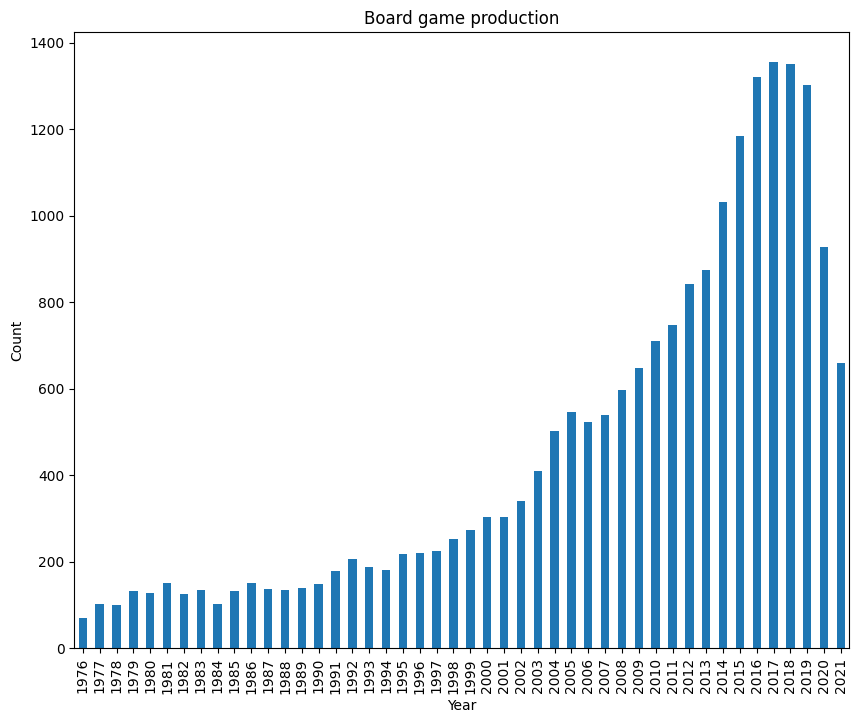

In [11]:
import matplotlib.pyplot as plt

grouped = df_years.groupby(df_years)

group_counts = grouped.size()

plt.subplots(figsize=(10, 8))
group_counts.plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Board game production')

plt.show()

Jak widać na serwisie BGG z biegiem lat pojawiało się coraz więcej nowych gier. Spadek nastąpił koło roku 2020. Możliwe, że miał on związek z trudną sytuacją ekonomiczną będącą konsekwencją pandemii.

### 2. Popularność gier należących do konkretnych kategorii

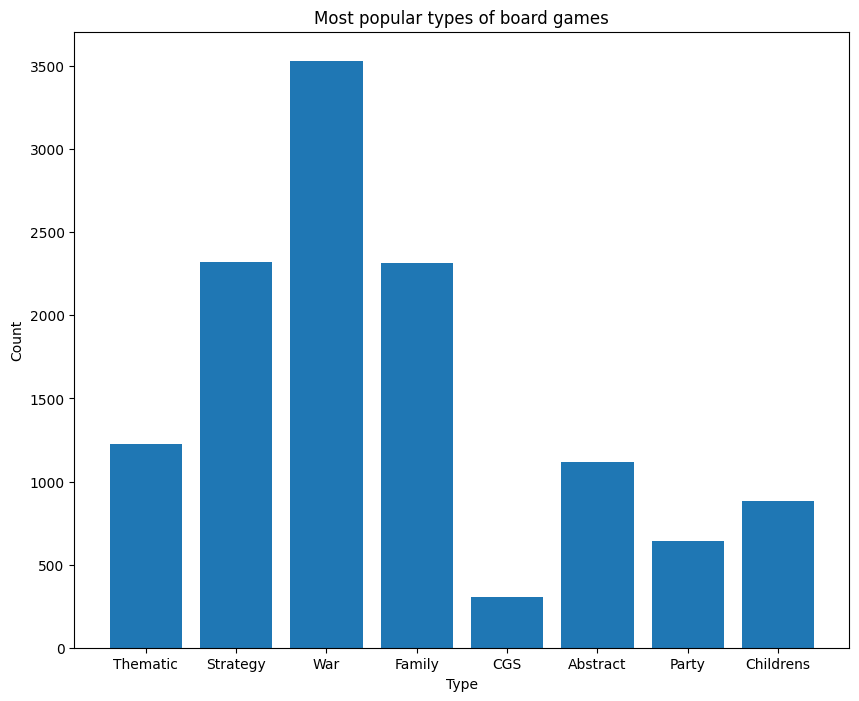

In [12]:
categories = [col[col.find(":") + 1:] for col in df.columns if col.startswith('Cat:')]
values = [df[f"Cat:{v}"].sum() for v in categories]

plt.subplots(figsize=(10, 8))
plt.bar(categories, values)
plt.xlabel('Type')
plt.ylabel('Count')
plt.title('Most popular types of board games')

plt.show()

Najliczniej reprezentowane gatunki stanowią gry wojenne, strategiczne i familijne. W kolejnym kroku postaram się sprawdzić, czy gatunki te należą również do najlepiej ocenianych.

### 3. Optymalna liczba graczy

In [13]:
bp_zero = df.groupby('BestPlayers').size().values[0]
bp_zero

19944

In [14]:
df_bp = df[df['BestPlayers'] != 0]

Wiele gier w zbiorze danych nie posiada własnościwości BestPlayers (jest równa 0), uznałem również, że próba estymowania wartości jest bezcelowa, bo braki występują dla ponad 90% gier. Skupię się więc na próbce gier, dla ktorych liczba ta została podana

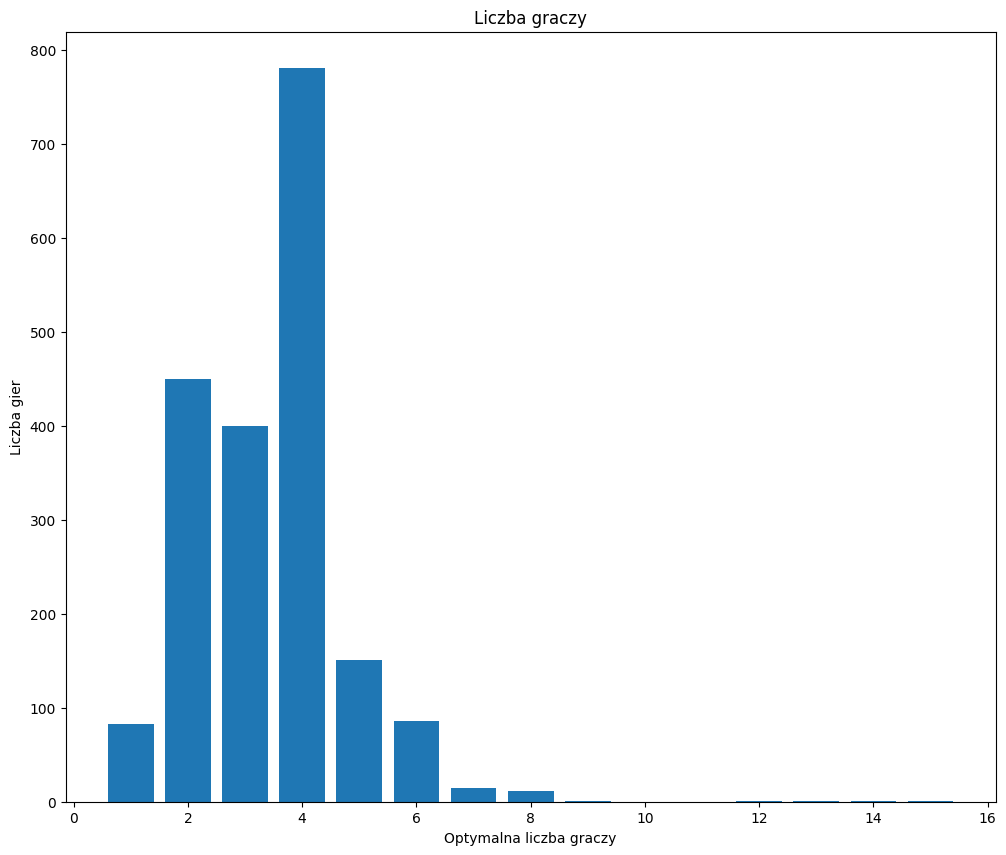

In [15]:
counts = df_bp.groupby('BestPlayers').size()

# plot the counts as a bar chart
plt.figure(figsize=(12, 10))
plt.bar(counts.index, counts.values)

# add x and y axis labels and a title
plt.xlabel('Optymalna liczba graczy')
plt.ylabel('Liczba gier')
plt.title('Liczba graczy')

# show the plot
plt.show()

In [16]:
get_descriptive_stats(df_bp['BestPlayers'])

Podstawowe:
count    1981.000000
mean        3.447754
std         1.337086
min         1.000000
25%         2.000000
50%         4.000000
75%         4.000000
max        15.000000
Name: BestPlayers, dtype: float64

Wartości unikatowych: 13
Skośność: 1.1848326058119778
Kurtoza: 6.745632800605776
Rozstęp: 14


Tak jak przypuszczałem optymalana liczba graczy wynosi 4 osoby, często występuje również wartość 2, jako że wiele gier jest przeznaczona dla dokładnie dwuch osób

### 4. Najlepiej oceniane gry - szeregi rozdzielcze
Podczas obliczeń zamierzam wykorzystać BayesAvgRating, które jest estymacją mediany ocen danej gry planszowej - parametr ten potraktuję jako jej indywidualną ocenę w skali od 1 do 10. Typ razem wylosuję z populacji próbki po 100 gier z każdej kategorii w celu sporządzenia szeregu. Próbki wybrałem jedynie z gier należących do dokładnie jednej kategorii.

Uporządkowanie danych w celu wylosowania próbek

In [17]:
columns_to_check = [col for col in df.columns if col.startswith('Cat:')]
cats_named = df[columns_to_check].apply(lambda row: '' if row.sum() > 1 else row[row == 1].index[0].split(':')[1] if 1 in row.values else '', axis=1)

In [18]:
cats_df = pd.concat([cats_named, df['BayesAvgRating']], axis=1)
cats_df = cats_df.rename(columns={cats_df.columns[0]: 'Category'})
cats_df = cats_df[cats_df["Category"] != '']

In [19]:
print(cats_df.head())

   Category  BayesAvgRating
0  Strategy         7.10363
1  Strategy         5.78447
2  Strategy         7.23994
4  Strategy         7.14189
6  Abstract         6.13713


Utorzenie słownika zawierającego próbki 100 elementów dla każdej kategorii 

In [20]:
cats_df["Category"].unique()

array(['Strategy', 'Abstract', 'Family', 'CGS', 'Thematic', 'War',
       'Party', 'Childrens'], dtype=object)

In [21]:
mn, mx = 10, 0
samples = dict()
for name in cats_df["Category"].unique():
  samples[name] = list(cats_df.loc[cats_df['Category'] == name, 'BayesAvgRating'].sample(n=100))
  mn = min(mn, min(samples[name]))
  mx = max(mx, max(samples[name]))

In [22]:
samples_df = pd.DataFrame(samples) # Visualization
samples_df

,Strategy,Abstract,Family,CGS,Thematic,War,Party,Childrens
0,5.70766,6.38633,5.52138,5.51275,6.17157,5.54447,7.13481,5.56075
1,6.34813,5.52160,6.16254,5.89744,5.48962,5.88020,5.54959,5.49428
2,6.90388,5.48243,5.94443,6.08280,5.66607,5.58723,7.01299,5.51123
3,7.42125,5.48200,5.75331,5.50211,5.61343,5.53739,5.73378,5.49970
4,6.83381,5.51044,5.58023,6.08206,5.70834,5.50427,5.48376,5.45707
...,...,...,...,...,...,...,...,...
95,5.86152,5.50875,5.85919,5.46118,5.82617,5.60635,5.48712,5.48588
96,6.25969,5.54506,5.67456,5.51976,5.59655,5.50043,6.30162,5.52534
97,5.79212,5.62231,5.74232,5.56769,5.55840,5.54894,5.59546,5.60834
98,5.81182,5.47876,6.30870,5.86274,6.28813,5.53563,6.19379,5.51817


Za liczbę klas w szeregu rozdzielczym przyjąłem pierwiastek z n, czyli w tym przypadku 10.

In [23]:
import math

cn = math.sqrt(len(samples['Strategy']))
ln = (mx - mn) / cn

print(f"Rozstęp: {mx - mn}")
print(f"Min: {mn}")
print(f"Max: {mx}")
print(f"Liczba klas: {cn}")
print(f"Długość przedziału: {ln}")

Rozstęp: 3.6188800000000008
Min: 4.51131
Max: 8.13019
Liczba klas: 10.0
Długość przedziału: 0.3618880000000001


Na potrzeby utworzenia szeregów oraz późniejszego badania hipotez wybrałem dwie kategorie gier do porównania: gry strategiczne - mój ulubiony gatunek gier planszowych oraz gry imprezowe, które w zbiorze pojawiają się zdecydowanie rzadziej. Postaram się zbadać, czy ma to związek z wysokością ocen obu gatunków.

In [24]:
ranges = [mn + x * ln for x in range(11)]
middles = [round((ranges[i] + ranges[i+1]) / 2, 2) for i in range(10)]

categories = [f'{round(i, 2)}-{round(i + ln, 2)}' for i in ranges[:-1]]

middles

[4.69, 5.05, 5.42, 5.78, 6.14, 6.5, 6.86, 7.23, 7.59, 7.95]

In [25]:
len(ranges), len(categories)

(11, 10)

In [63]:
def create_series(column, ranges = ranges, middles = middles):
  comp_df = pd.DataFrame()
  comp_df["Range"] = pd.cut(column, bins=ranges, labels=categories)
  grouped_df = comp_df.groupby('Range').size().reset_index(name='Count')
  grouped_df["Middle"] = middles
  return grouped_df

In [74]:
strategy_df = create_series(samples_df["Strategy"])

In [75]:
strategy_df

,Range,Count,Middle
0,4.51-4.87,0,4.69
1,4.87-5.24,0,5.05
2,5.24-5.6,9,5.42
3,5.6-5.96,35,5.78
4,5.96-6.32,20,6.14
5,6.32-6.68,14,6.50
6,6.68-7.04,9,6.86
7,7.04-7.41,6,7.23
8,7.41-7.77,6,7.59
9,7.77-8.13,1,7.95


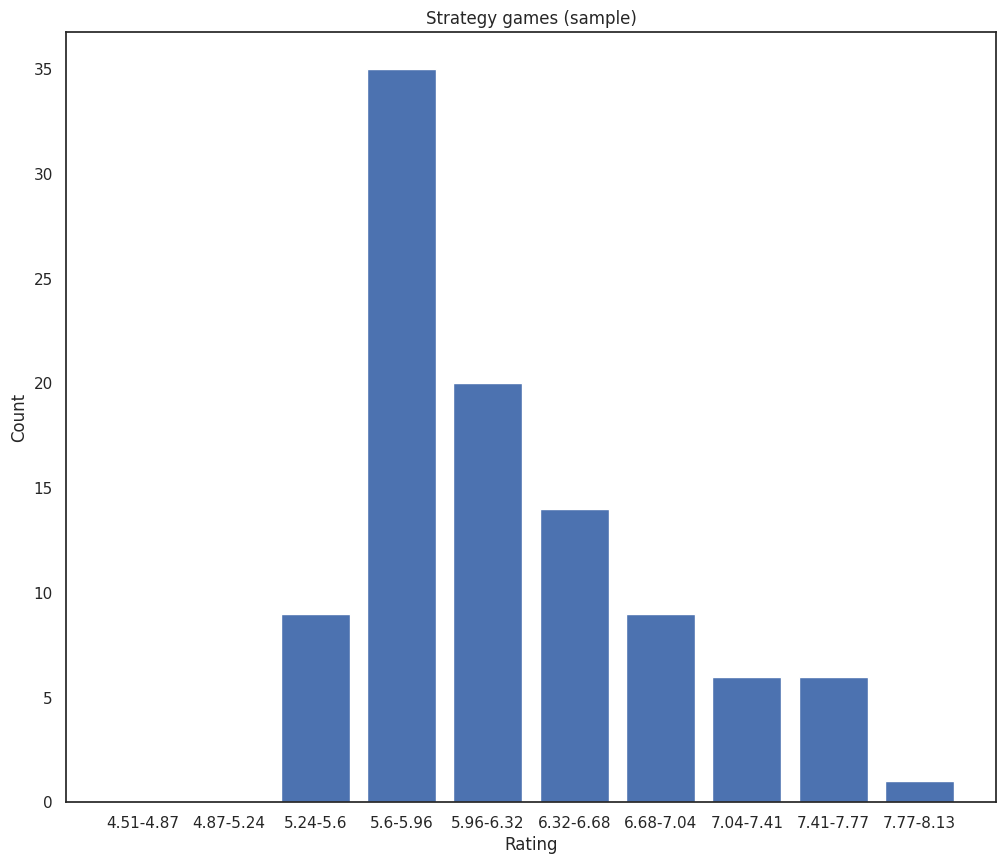

In [68]:
# plot the counts as a bar chart
plt.figure(figsize=(12, 10))
plt.bar(strategy_df["Range"], strategy_df["Count"])

# add x and y axis labels and a title
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Strategy games (sample)')

# show the plot
plt.show()

In [69]:
party_df = create_series(samples_df["Party"])

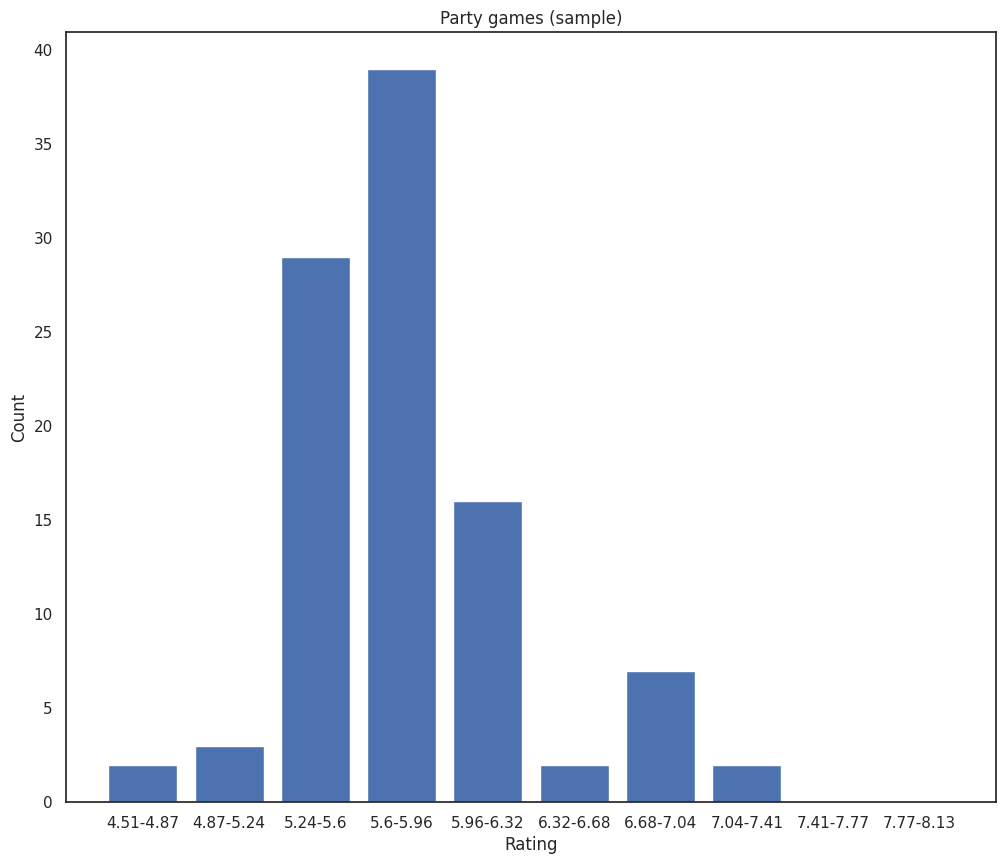

In [70]:
# plot the counts as a bar chart
plt.figure(figsize=(12, 10))
plt.bar(party_df["Range"], party_df["Count"])

# add x and y axis labels and a title
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Party games (sample)')

# show the plot
plt.show()

In [76]:
import numpy as np


def get_array_desc(df, ln = ln):
  avg = (df['Count'].astype(np.float16) * df['Middle'].astype(np.float16)).sum() / df['Count'].astype(np.float16).sum()
  var = (pow(df['Middle'].astype(np.float16) - avg, 2) * df['Count'].astype(np.float16)).sum() / df['Count'].astype(np.float16).sum()
  std = round(math.sqrt(var), 4)
  
  ind = df[df["Count"].cumsum() > (df["Count"].sum() + 1) / 2].index[0]
  x0 = (df.loc[ind]["Middle"] + df.loc[max(ind - 1, 0)]["Middle"]) / 2
  nj = df.loc[ind]["Count"]
  cum_nj = df["Count"].cumsum().iloc[max(ind - 1, 0)]
  n2 = df['Count'].astype(np.int8).sum() / 2

  median = x0 + (ln * (n2 - cum_nj)) / nj

  print(f"Średnia: {avg}")
  print(f"Mediana: {median}")
  print(f"Wariancja: {var}")
  print(f"Odchylenie standardowe: {std}")

Przygotowałem również funkcję służącą do obliczenia statystyk opisowych dla szeregów

In [77]:
print("Gry strategiczne")
get_array_desc(strategy_df)
print("\nGry imprezowe")
get_array_desc(party_df)

Gry strategiczne
Średnia: 6.234375
Mediana: 6.0685664
Wariancja: 0.377197265625
Odchylenie standardowe: 0.6142

Gry imprezowe
Średnia: 5.80859375
Mediana: 5.7484668717948715
Wariancja: 0.2308349609375
Odchylenie standardowe: 0.4805


Wydaje się, że użytkownicy BGG preferują gry strategiczne, niż imprezowe. Prawdziwość tej hipotezy postaram się zbadać w dalszej części zadania.

### 4. Korelacja

<ipython-input-78-be2ea55652de>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_cp.corr()


<Axes: >

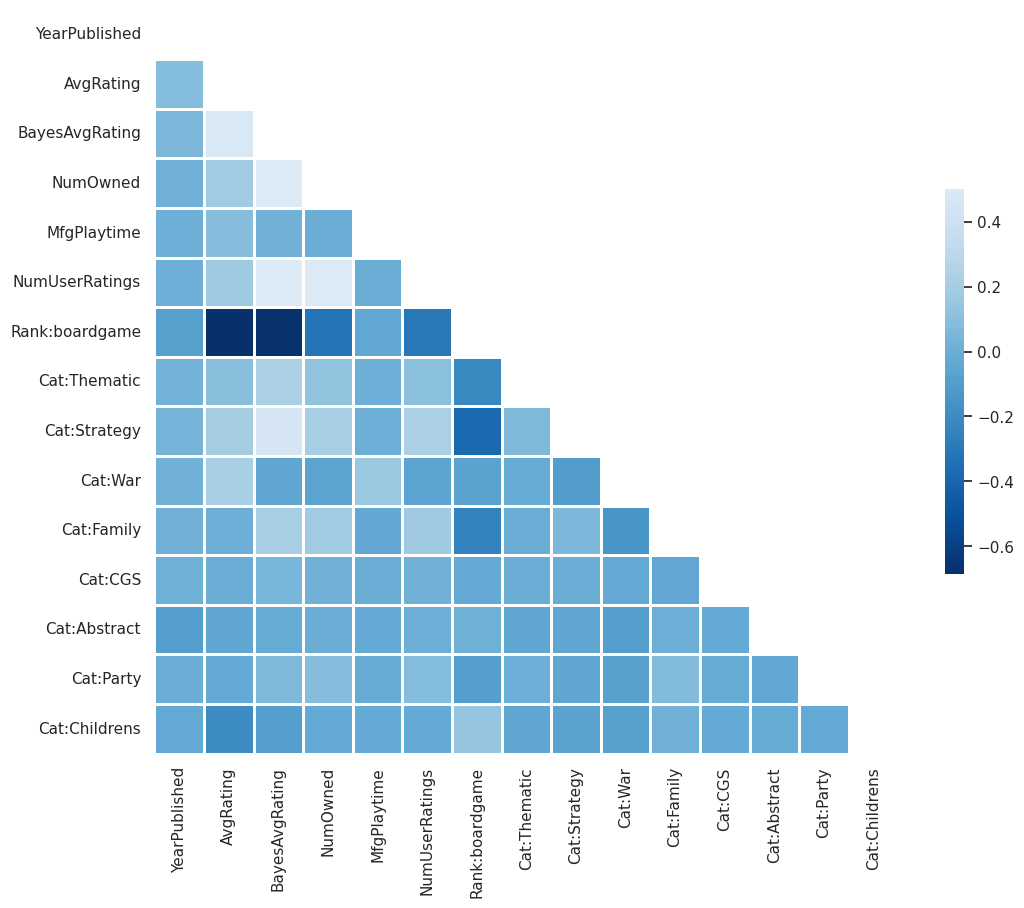

In [78]:
import seaborn as sns

df_cp = df.drop(["StdDev", "BestPlayers"], axis=1)

corr = df_cp.corr()

sns.set_theme(style="white")
fig, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.color_palette("Blues_r", as_cmap=True)

sns.heatmap(corr, mask=mask, cmap = cmap, vmax=.5, linewidths=1, center=0, square=True, cbar_kws={"shrink": .5})

Między niektórymi parametrami występuje umiarkowana korelacja. Dodatnia korelacja dotyczy przede wszystkim:
* Średniej oraz estymacji mediany
* Liczby ocen i liczbą posiadaczy gry

Z kolei ujemna korelacja pojawia się między:
* Pozycją w rankingu a oceną
* W delikatnym stopniu liczbą posiadaczy a pozycją oraz liczbą ocen a pozycją

Dodatkowo na grafie widoczna jest delikatna przewaga gier strategicznych dotycząca wysokości ocen, zauważalna również na wykresach kolumnowych w poprzednim punkcie

Podsumowując: analiza wartości korelacji między parametrami nie dostarczyła mi nowych informacji na temat zbioru danych.


## Przykładowe testy statystyczne

### Hipoteza numer 1 - rozkład ocen losowo wybranej próbki z populcji jest taki sam jak rozkład wartości w całej populacji
Jako że posiadam wiedzę dotyczącą całej populacji mogę łatwo sprawdzić, czy rozkład ocen próbki 100 gier strategicznych nie odbiega od rozkładu ocen dla całej populacji gier strategicznych. Tym razem podzielę wartości punktacji na przedziały rozmiaru 1, jako że przedziały utworzone w podpunkcie dotyczącym szeregu nie obejmują wszystkich możliwych punktacji dla gier strategicznych.

In [101]:
ranges = range(0, 11)
categories = [f'{i}-{i + 1}' for i in ranges[:-1]]

range(0, 11) ['0-1', '1-2', '2-3', '3-4', '4-5', '5-6', '6-7', '7-8', '8-9', '9-10']


In [104]:
full_pop_str = df[df["Cat:Strategy"] == 1]["BayesAvgRating"]

pop_distr = pd.DataFrame()
pop_distr["Range"] = pd.cut(full_pop_str, bins=ranges, labels=categories)
pop_distr = pop_distr.groupby('Range').size().reset_index(name='Count')

sample_distr = pd.DataFrame()
sample_distr["Range"] = pd.cut(samples["Strategy"], bins=ranges, labels=categories)
sample_distr = sample_distr.groupby('Range').size().reset_index(name='Count')

In [107]:
pop_distr, sample_distr

(  Range  Count
 0   0-1      0
 1   1-2      0
 2   2-3      0
 3   3-4      0
 4   4-5      0
 5   5-6   1164
 6   6-7    900
 7   7-8    242
 8   8-9     13
 9  9-10      0,
   Range  Count
 0   0-1      0
 1   1-2      0
 2   2-3      0
 3   3-4      0
 4   4-5      0
 5   5-6     45
 6   6-7     42
 7   7-8     12
 8   8-9      1
 9  9-10      0)

In [131]:
data = pd.DataFrame()
data["Range"] = pop_distr["Range"]
data["Prob_dist"] = (pop_distr["Count"] / pop_distr["Count"].sum()).astype(np.float16)
data["Observed_freq"] = sample_distr["Count"].astype(np.float16)
data['Expected_freq'] = (data['Observed_freq'].sum() * data['Prob_dist']).astype(np.float16)
data = data[(data['Expected_freq'] != 0) & (data['Observed_freq'] != 0)] # Usunąłem wiersze o wartości 0, ponieważ generowały błędy w dalszej części kodu
data

,Range,Prob_dist,Observed_freq,Expected_freq
5,5-6,0.501953,45.0,50.187500
6,6-7,0.388184,42.0,38.812500
7,7-8,0.104370,12.0,10.437500
8,8-9,0.005608,1.0,0.560547


Hipoteza zerowa - dane mają ten sam rozkład

Hipoteza alternatywna - dane mają różne rozkłady

Rodzaj testu - test chi-squared

In [134]:
import scipy.stats as stats

alpha = 0.05 # poziom istotności

chi_square = 0
for i in range(5, 9):
    O = data.loc[i, 'Observed_freq']
    E = data.loc[i, 'Expected_freq']
    chi_square += (O-E) ** 2 / E

critical_value = stats.chi2.ppf(1-alpha, data['Range'].nunique() - 1)
conclusion = "Nie udało się odrzucić hipotezy zerowej."
if chi_square > critical_value:
    conclusion = "Hipoteza zerowa zostałą odrzucona."
        
print("Wynik testu:", chi_square)
print("Wartość krytyczna", critical_value)
print(conclusion)

Wynik testu: 1.3763939518700472
Wartość krytyczna 7.814727903251179
Nie udało się odrzucić hipotezy zerowej.


Wniosek - pobrana losowo próbka zachowuje ten sam rozkład wartości co cała populacja, więc mogę ją wykorzystać w kolejnych testach

### Hipoteza numer 2 - gry strategiczne otrzymują oceny wyższe od średniej

In [79]:
get_descriptive_stats(df["BayesAvgRating"])

Podstawowe:
count    21925.000000
mean         5.685673
std          0.365311
min          3.574810
25%          5.510300
50%          5.546540
75%          5.679890
max          8.514880
Name: BayesAvgRating, dtype: float64

Wartości unikatowych: 15950
Skośność: 2.8544084816398474
Kurtoza: 10.029189454859733
Rozstęp: 4.94007


In [80]:
print("Gry strategiczne")
get_array_desc(strategy_df)

Gry strategiczne
Średnia: 6.234375
Mediana: 6.0685664
Wariancja: 0.377197265625
Odchylenie standardowe: 0.6142


In [85]:
pop_avg = 5.686 # średnia populacji u
pop_std = 0.365 # odchylenie standardowe w populacji

str_avg = 6.234 # średnia z próby
str_count = 100 # rozmiar próby n

a = 0.05 # poziom istotności
test_type = "r" # rodzaj testu

Hipoteza zerowa - gry strategiczne otrzymują średnio takie same oceny jak inne gry

Hipoteza alternatywna - gry strategiczne otrzymują średnio wyższe oceny niż inne gry

Rodzaj testu - test Z

In [91]:
from scipy.stats import norm, t

def test_z(p0, p_hat, alpha, n, sigma, test_type):
    z = math.sqrt(n) * (p_hat - p0) / sigma  # test statistic
    z_crit = round(norm.ppf(1 - alpha), 3)
    if test_type == "l":
        print("Obszar krytyczny: ", "(-inf, ", -z_crit, ")")
    elif test_type == "r":
        print("Obszar krytyczny: ", "(", z_crit, ", inf)")
    elif test_type == "b":
        print("Obszary krytyczne: ", "(-inf, ", -z_crit, ")\n", "(", z_crit, ", inf )")

    print("Wartość statystyki testowej:", round(z, 3))

    if (test_type == "l" and z < -z_crit) or (test_type == "r" and z > z_crit) or (
            test_type == "b" and (z > z_crit or z < -z_crit)):
        print("Odrzucamy H0 na rzecz H1")
    else:
        print("Brak podstaw do odrzucenia H0")

In [92]:
test_z(pop_avg, str_avg, a, str_count, pop_std, test_type)

Obszar krytyczny:  ( 1.645 , inf)
Wartość statystyki testowej: 15.014
Odrzucamy H0 na rzecz H1


Ten sam test powtórzyłem dla oryginalnych danych - tym razem zamiast podzielonych na przedziały wartości pochodzących z szeregu wykorzystałem oryginalną próbkę, a także funkcję służącą do przeprowadzania testu Z pochodzącą z biblioteki statsmodels

In [93]:
from statsmodels.stats.weightstats import ztest as ztest
z_test = ztest(samples["Strategy"], value=5.686)
print(f"Wartość statystyki testowej: {round(z_test[0], 3)}")
print(f"P-value: {round(z_test[1], 3)}")

Wartość statystyki testowej: 8.972
P-value: 0.0


Wartość p jest tak niska, że została zaokrąglona do 0.

Ostatecznie odrzucamy himpotezę zerową na korzyść alternatywnej - gry strategiczne faktycznie mają śrenio wyższe oceny w serwisie

W obu testach zastosowałem poziom istotności alfa wynoszący 5% - jest to prawdopodobieństwo, że popełniłem błąd **pierwszego rodzaju**

# Wnioski

Większość obserwacji zawarłem już w komentarzach do poszczególnych podpunktów, jednak postaram się sporządzić krotkie podsumowanie:

Motywacje wyborów: Przede wszystkim zależało mi na znalezieniu najczęściej posiadanych przez użytkowników serwisu typów gier. Chciałem się również dowiedzieć, jak plasuje mój ulubiony gatunek gier planszowych na tle innych popularnych typów.


Wnioski: Poczynione obserwacje jedynie częściowo zgadzały się z moimi przypuszczeniami.
* Nie dziwi mnie na przykład, że dużą część stanowiły gry cztero i dwu osobowe. Gry dwuosobowe są idealne dla ludzi, którzy nie mają czasu na organizowanie większych spotkań, z kolei 4 osobowe gry są łatwiejsze do zbalansowania niż 3 osobowe, a ich czas trwania nie jest tak duży jak gier pięcioosobowych, ze względu na np. konieczność czekania na swoją turę. Są idealne do rozegrania w rodzinnie lub w niewielkiej grupce znajomych.
* Zaskoczył mnie fakt, że bardzo często produkowane są gry strategiczne i wojenne. W tym przypadku spodziewam się, że dane są lekko tendencyjne. BGG to serwis dla fanów planszówek, informacje zostały więc pozyskane od grona odbiorców, którzy najprawdopodobniej preferują gry bardziej nastawione na strategiczne myślenie, niż prostotę rozgrywki. Osobiście uważam, że gdyby ankietę popularności przeprowadzić w losowo wybranej grupie ludzi dużo popularniejsze okazałyby się gry imprezowe lub familijne, o niższej złożoności zasad (choć gry familijne i tak znalazły się w trójce najpopularniejszych gatunków).

Dalsze kroki:
* Przeprowadzenie wspomnianej przeze mnie ankiety w losowej grupie ludzi nie będącyh koniecznie użytkownikami serisu.
* Zbadanie faktu, dlaczego produkcja gier zmalała znacznie po roku 2019? Czy ma to związek z pandemią i kryzysem ekonomicznym? Czy może spowodowane to było innymi czynnikami?
* Zbadanie rozkłądów ocen i pozycji w rankingu innych typów gier - wyłonienie najlepszego typu gier nie tyle według ilości gier danego gaunku, a wedle średniej wartości ocen.
* Zbadanie korelacji i wspólnych parametrów najlepszych gier. Czy gry czteroosobowe faktycznie dostają średnio lepsze oceny? Jak duży wpływ na oceny ma czas gry?
